## Newton Method

### Quadratic Energy Minimization
We are minimizing the following energy functional, using a Netwon method based on the TF Hessian library.
$$J(x,y) = x^2y^2+xy$$

which is the unique stationary point of $\nabla J$ given the fact that $J(x,y)$ is convex.

In [1]:
#We import all the library we are gona need
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from numsa.TFHessian import *

In [2]:
itmax = 10; # Number of epoch.
tol = 1e-6
step_size = 1; #Learning rate
def Loss(x):
    return (x[0]**2)*(x[1]**2)+x[0]*x[1];
#Defining the Hessian class for the above loss function in x0
x = tf.Variable(0.1*np.ones((2,1),dtype=np.float32))
H =  Hessian(Loss,x)
grad = H.grad().numpy();
print("Lost funciton at this iteration {}, gradient norm {} and is achived at point {}"
      .format(Loss(x),np.linalg.norm(grad),x));
print("Computed the  first gradient ...")
q = H.pCG(grad,1,1,tol=tol,itmax=100);
print("Computed search search diratcion ...")
print("Entering the Netwton optimization loop")
for it in tqdm(range(itmax)):
    x = x - tf.constant(step_size,dtype=np.float32)*tf.Variable(q,dtype=np.float32);
    x =  tf.Variable(x)
    if it%50 == 0:
        print("Lost funciton at this iteration {}  and gradient norm {}".format(Loss(x),np.linalg.norm(grad)));
    if np.linalg.norm(grad)<tol:
        print("Lost funciton at this iteration {}, gradient norm {} and is achived at point {}"
      .format(Loss(x),np.linalg.norm(grad),x));
        break
    H =  Hessian(Loss,x)
    grad = H.grad().numpy();
    q = H.pCG(grad,1,1,tol=tol,itmax=100);

Lost funciton at this iteration [0.0101], gradient norm 0.1442497819662094 and is achived at point <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.1],
       [0.1]], dtype=float32)>
Computed the  first gradient ...


 20%|██        | 2/10 [00:00<00:00, 13.67it/s]

Computed search search diratcion ...
Entering the Netwton optimization loop
Lost funciton at this iteration [1.4240287e-05]  and gradient norm 0.1442497819662094
Lost funciton at this iteration [-9.060207e-17], gradient norm 3.0079988277975644e-07 and is achived at point <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-4.7550657e-09],
       [ 1.9053800e-08]], dtype=float32)>


### Regression
Our objective is to minimize the function:
\begin{equation}
    f(\vec{x}) = \frac{1}{m} \sum_{i=1}^m \log\Bigg(1+\exp\Big(-b_j \vec{a_j}^T\vec{x}\Big)\Bigg)\qquad for \; x \in \mathbb{R}^d
\end{equation}

where $d$ is the feature number and $\vec{a}_j$ are the data while $b_j$ are the labels.
Now we would like to this applying the newton method to find a point that minimize such a function. This is possible because since $f$ is convex, all stationary points are minimizers and we search for the "roots" of the equation $\nabla f=0$.
The newton method we implement is of the form,
\begin{equation}
    \vec{x}_{n+1} = \vec{x}_n -\gamma Hf(\vec{x}_n)^{-1}\nabla f(\vec{x}_n)
\end{equation}

where $\gamma$ is the step size.
We solve the system $Hf(\vec{x}_n)q=\nabla f(\vec{x}_n)$ using the CG method where as a preconditioned we have taken a the inverse of $Hf(\vec{x}_n)$ computed using the random SVD presented in [1].

In [3]:
#We import all the library we are gona need
import tensorflow as tf
import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
from numsa.TFHessian import *
import dsdl

In [4]:
ds = dsdl.load("a1a")

X, Y = ds.get_train()
print(X.shape, Y.shape)

(1605, 119) (1605,)


In [5]:
#Setting the parameter of this run, we will use optimization nomeclature not ML one.
itmax = 100; # Number of epoch.
tol = 1e-4
step_size = 0.2; #Learning rate
Err = [];
"""
#Old Lost Function, intesead using Stefano's.
#Defining the Loss Function
def Loss(x):
    S = tf.Variable(0.0);
    for j in range(X.shape[0]):
        a = tf.constant((X[j,:].todense().reshape(119,1)),dtype=np.float32);
        b = tf.constant(Y[j],dtype=np.float32)
        a = tf.reshape(a,(119,1));
        x = tf.reshape(x,(119,1));
        dot = tf.matmul(tf.transpose(a),x);
        S = S+tf.math.log(1+tf.math.exp(-b*dot))
    S = (1/X.shape[0])*S;
    return S;
"""
tfX = tf.sparse.from_dense(np.array(X.todense(), dtype=np.float32))
tfY = tf.convert_to_tensor(np.array(Y, dtype=np.float32).reshape(X.shape[0], 1))


#Defining the Loss Function
def Loss(x):
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfX, x, adjoint_a=False)
    Z = tf.math.multiply(tfY, Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfX.shape[0])
    return S

#Defining the Hessian class for the above loss function in x0
x = tf.Variable(0.1*np.ones((119,1),dtype=np.float32))
H =  Hessian(Loss,x)
grad = H.grad().numpy();
print("Computed the  first gradient ...")
q = grad #H.pCG(grad,10,2,tol=1e-3,itmax=10);
print("Computed search search diratcion ...")
for it in tqdm(range(itmax)):
    x = x - tf.constant(step_size,dtype=np.float32)*tf.Variable(q,dtype=np.float32);
    x =  tf.Variable(x)
    if it%50 == 0:
        print("Lost funciton at this iteration {}  and gradient norm {}".format(Loss(x),np.linalg.norm(grad)));
    if np.linalg.norm(grad)<tol:
        break
    H =  Hessian(Loss,x)
    grad = H.grad().numpy();
    q = grad #H.pCG(grad,10,2,tol=1e-3,itmax=10);
itmax = 100; # Number of epoch.
for it in tqdm(range(itmax)):
    x = x - tf.constant(step_size,dtype=np.float32)*tf.Variable(q,dtype=np.float32);
    x =  tf.Variable(x)
    Err = Err + [np.linalg.norm(grad)];
    if it%10 == 0:
        print("Lost funciton at this iteration {}  and gradient norm {}".format(Loss(x),np.linalg.norm(grad)));
    if np.linalg.norm(grad)<tol:
        break
    H =  Hessian(Loss,x)
    grad = H.grad().numpy();
    q = H.pCG(grad,65,10,tol=1e-4,itmax=100);

 20%|██        | 20/100 [00:00<00:00, 193.69it/s]

Computed the  first gradient ...
Computed search search diratcion ...
Lost funciton at this iteration 0.9243690371513367  and gradient norm 1.3872039318084717


 81%|████████  | 81/100 [00:00<00:00, 199.51it/s]

Lost funciton at this iteration 0.3988267183303833  and gradient norm 0.07041343301534653


  0%|          | 0/100 [00:00<?, ?it/s]

Lost funciton at this iteration 0.37019962072372437  and gradient norm 0.041932351887226105


 10%|█         | 10/100 [00:35<05:14,  3.50s/it]

Lost funciton at this iteration 0.3072308301925659  and gradient norm 0.006752993445843458


 20%|██        | 20/100 [01:10<04:35,  3.44s/it]

Lost funciton at this iteration 0.30269062519073486  and gradient norm 0.0011640462325885892


 30%|███       | 30/100 [01:45<04:02,  3.47s/it]

Lost funciton at this iteration 0.30072298645973206  and gradient norm 0.0007762470631860197


 40%|████      | 40/100 [02:20<03:26,  3.45s/it]

Lost funciton at this iteration 0.2988802492618561  and gradient norm 0.00027924508322030306


 50%|█████     | 50/100 [02:54<02:55,  3.51s/it]

Lost funciton at this iteration 0.2984878718852997  and gradient norm 0.0001676468673394993


 57%|█████▋    | 57/100 [03:19<02:30,  3.50s/it]


In [6]:
print("Lost funciton at this iteration {}  and gradient norm {}".format(Loss(x),np.linalg.norm(grad)));

Lost funciton at this iteration 0.29834863543510437  and gradient norm 9.871969814412296e-05


### Quasi-Newton Method

In [8]:
#We import all the library we are gona need
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from numsa.TFHessian import *
import dsdl

In [11]:
ds = dsdl.load("a1a")
X, Y = ds.get_train()
print(X.shape, Y.shape)

(1605, 119) (1605,)


In [9]:
#Setting the parameter of this run, we will use optimization nomeclature not ML one.
itmax = 20; # Number of epoch.
tol = 1e-4
step_size = 0.2; #Learning rate
Err = [];
Hs = [];
Rsigmas50 = [];
Rsigmas80 = [];
"""
#Old Lost Function, intesead using Stefano's.
#Defining the Loss Function
def Loss(x):
    S = tf.Variable(0.0);
    for j in range(X.shape[0]):
        a = tf.constant((X[j,:].todense().reshape(119,1)),dtype=np.float32);
        b = tf.constant(Y[j],dtype=np.float32)
        a = tf.reshape(a,(119,1));
        x = tf.reshape(x,(119,1));
        dot = tf.matmul(tf.transpose(a),x);
        S = S+tf.math.log(1+tf.math.exp(-b*dot))
    S = (1/X.shape[0])*S;
    return S;
"""
tfX = tf.sparse.from_dense(np.array(X.todense(), dtype=np.float32))
tfY = tf.convert_to_tensor(np.array(Y, dtype=np.float32).reshape(X.shape[0], 1))


#Defining the Loss Function
def Loss(x):
    lam = 1e-3
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfX, x, adjoint_a=False)
    Z = tf.math.multiply(tfY, Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfX.shape[0])#+lam*tf.norm(x)**2
    return S
#Defining the Hessian class for the above loss function in x0
x = tf.Variable(0.1*np.ones((119,1),dtype=np.float32))
H =  Hessian(Loss,x)
grad = H.grad().numpy();
q = grad;
itmax = 100; # Number of epoch.
for it in tqdm(range(itmax)):
    x = x - tf.constant(step_size,dtype=np.float32)*tf.Variable(q,dtype=np.float32);
    x =  tf.Variable(x)
    Err = Err + [np.linalg.norm(grad)];
    if it%5 == 0:
        print("Lost funciton at this iteration {}  and gradient norm {}".format(Loss(x),np.linalg.norm(grad)));
        Hs = Hs + [H.mat()];
    if np.linalg.norm(grad)<tol:
        break
    H =  Hessian(Loss,x)
    grad = H.grad().numpy();
    U, s, Vt = H.RandMatSVD(50,10)
    if it%5 == 0:
        Rsigmas50 = Rsigmas50 + [s];
    U, s, Vt = H.RandMatSVD(80,10)
    if it%5 == 0:
        Rsigmas80 = Rsigmas80 + [s];
    q = (Vt.transpose()@np.linalg.inv(np.diag(s))@U.transpose())@grad;

  0%|          | 0/100 [00:00<?, ?it/s]

Lost funciton at this iteration 0.9243690371513367  and gradient norm 1.3872039318084717


  5%|▌         | 5/100 [00:36<11:00,  6.95s/it]

Lost funciton at this iteration 0.43581220507621765  and gradient norm 0.4351786673069


 10%|█         | 10/100 [01:12<10:24,  6.94s/it]

Lost funciton at this iteration 0.33864614367485046  and gradient norm 0.15352341532707214


 15%|█▌        | 15/100 [01:48<09:47,  6.91s/it]

Lost funciton at this iteration 0.3093506991863251  and gradient norm 0.05440719053149223


 20%|██        | 20/100 [02:24<09:09,  6.87s/it]

Lost funciton at this iteration 0.3009910583496094  and gradient norm 0.019055956974625587


 25%|██▌       | 25/100 [03:00<08:37,  6.90s/it]

Lost funciton at this iteration 0.2988140881061554  and gradient norm 0.006567216478288174


 30%|███       | 30/100 [03:36<08:07,  6.96s/it]

Lost funciton at this iteration 0.29820406436920166  and gradient norm 0.0022333976812660694


 35%|███▌      | 35/100 [04:12<07:30,  6.93s/it]

Lost funciton at this iteration 0.2980078160762787  and gradient norm 0.0007552480674348772


 40%|████      | 40/100 [04:48<06:56,  6.95s/it]

Lost funciton at this iteration 0.29793307185173035  and gradient norm 0.0002552660880610347


 45%|████▌     | 45/100 [05:25<06:23,  6.97s/it]

Lost funciton at this iteration 0.29789888858795166  and gradient norm 8.670691022416577e-05


 45%|████▌     | 45/100 [05:27<06:40,  7.28s/it]


In [10]:
np.save("Hs",Hs)
print("Lost funciton at this iteration {}  and gradient norm {}".format(Loss(x),np.linalg.norm(grad)));

Lost funciton at this iteration 0.29789888858795166  and gradient norm 8.670691022416577e-05


We would like to make a case for using the random SVD alghorithm in second order optimization problem. Let us consider the Hessian produced during in the in pevious example and show that given their quick decay the randomised SVD is a good approximation.

<IPython.core.display.Javascript object>


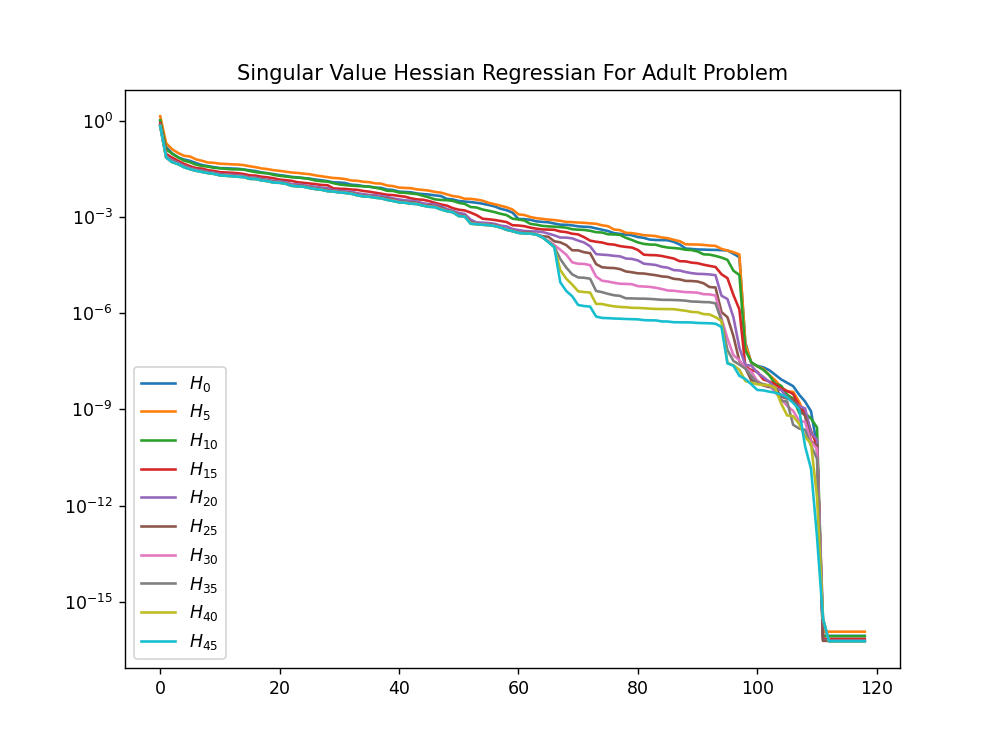

Text(0.5, 1.0, 'Singular Value Hessian Regressian For Adult Problem')

In [11]:
Hs = np.load("Hs.npy")
plt.figure()
for H in Hs:
    _, s,_ = np.linalg.svd(H)
    plt.semilogy(s)
plt.legend([r"$H_{"+str(5*i)+"}$" for i in range(len(Hs))],loc=3)
plt.title("Singular Value Hessian Regressian For Adult Problem")

<IPython.core.display.Javascript object>


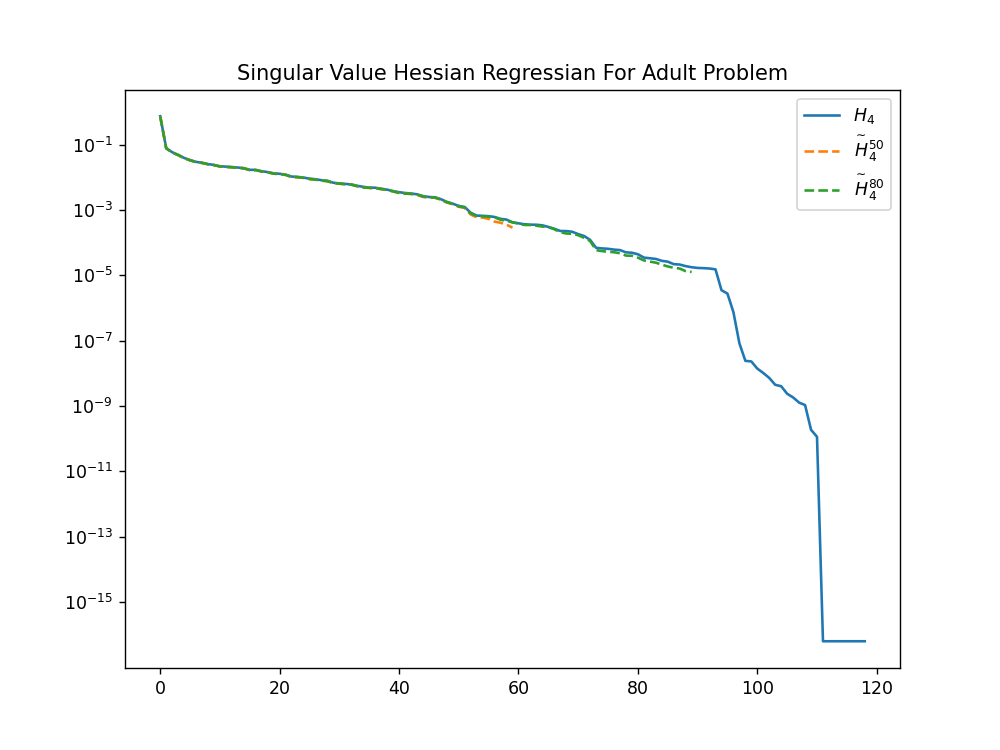

Text(0.5, 1.0, 'Singular Value Hessian Regressian For Adult Problem')

In [12]:
plt.figure()
_, s,_ = np.linalg.svd(Hs[4])
plt.semilogy(s)
plt.semilogy(Rsigmas50[4],"--")
plt.semilogy(Rsigmas80[4],"--")
plt.legend([r"$H_{4}$",r"$\overset{\sim}{H}_4^{50}$",r"$\overset{\sim}{H}_4^{80}$"])
plt.title("Singular Value Hessian Regressian For Adult Problem")

### MPI
We show below how to use the Quasi Newton method on multiple cores.

In [1]:
from ipyparallel import Client
c = Client()
c.ids

[0, 1]

In [2]:
%%px 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numsa.TFHessian import *
from mpi4py import MPI
import dsdl

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

In [3]:
%%px
itmax = 100; # Number of epoch.
tol = 1e-4
step_size = 0.4; #Learning rate
lam = 1e-3;

In [4]:
%%px
comm = MPI.COMM_WORLD

ds = dsdl.load("a1a")

X, Y = ds.get_train()
indx = np.array_split(range(X.shape[0]),int(comm.Get_size()));
tfX = []
tfY = []
tfXs = tf.sparse.from_dense(np.array(X.todense(), dtype=np.float32))
tfYs = tf.convert_to_tensor(np.array(Y, dtype=np.float32).reshape(X.shape[0], 1))
for k in range(len(indx)):
    tfX = tfX + [tf.sparse.from_dense(np.array(X[indx[comm.Get_rank()]].todense(), dtype=np.float32))]
    tfY = tfY + [tf.convert_to_tensor(np.array(Y[indx[comm.Get_rank()]], dtype=np.float32).reshape(X[indx[comm.Get_rank()]].shape[0], 1))]
#Defining the Loss Function
def LossSerial(x):
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfXs, x, adjoint_a=False)
    Z = tf.math.multiply(tfYs, Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfXs.shape[0])+lam*tf.norm(x)**2
    return S
def Loss(x,comm):
    x = tf.reshape(x, (119, 1))
    Z = tf.sparse.sparse_dense_matmul(tfX[comm.Get_rank()], x, adjoint_a=False)
    Z = tf.math.multiply(tfY[comm.Get_rank()], Z)
    S = tf.reduce_sum(tf.math.log(1 + tf.math.exp(-Z)) / tfX[comm.Get_rank()].shape[0])+lam*tf.norm(x)**2
    return S

In [ ]:
%%px
x = tf.Variable(0.1*np.ones((119,1),dtype=np.float32))
H =  Hessian(Loss,x)
grad = H.grad().numpy();
q = grad
#GRADIENT DESCENT
for it in tqdm(range(itmax)):
    x = x - tf.constant(step_size,dtype=np.float32)*tf.Variable(q,dtype=np.float32);
    x =  tf.Variable(x)
    if it%50 == 0:
        print("[Iteration. {}] Lost funciton at this iteration {}  and gradient norm {}".format(it,LossSerial(x),np.linalg.norm(grad)));
    if np.linalg.norm(grad)<tol:
        break
    H =  Hessian(Loss,x)
    grad = H.grad().numpy();
    q = grad
#NEWTON METHOD
x = H.comm.bcast(x,root=0);
q = H.comm.bcast(q,root=0);
grad = q
itmax = 200
for it in tqdm(range(itmax)):
    x = x - tf.constant(step_size,dtype=np.float32)*tf.Variable(q,dtype=np.float32);
    x =  tf.Variable(x)
    if it%5 == 0:
        print("[Iteration. {}] Lost funciton at this iteration {}  and gradient norm {}".format(it,LossSerial(x),np.linalg.norm(grad)));
    if np.linalg.norm(grad)<tol:
        break
    H =  Hessian(Loss,x)
    grad = H.grad().numpy();
    U, s, Vt = H.RandMatSVD(70,10)
    q = (Vt.transpose()@np.linalg.inv(np.diag(s))@U.transpose())@grad;

 23%|██▎       | 46/200 [03:04<10:18,  4.02s/it]


 23%|██▎       | 46/200 [03:04<10:13,  3.99s/it]

[stdout:0] [Iteration. 0] Lost funciton at this iteration 0.6866949200630188  and gradient norm 1.3883576393127441
[Iteration. 50] Lost funciton at this iteration 0.3794311285018921  and gradient norm 0.03935262933373451
[Iteration. 0] Lost funciton at this iteration 0.3619699776172638  and gradient norm 0.02337537333369255
[Iteration. 5] Lost funciton at this iteration 0.34870174527168274  and gradient norm 0.010573619976639748
[Iteration. 10] Lost funciton at this iteration 0.34821632504463196  and gradient norm 0.004498184192925692
[Iteration. 15] Lost funciton at this iteration 0.34894078969955444  and gradient norm 0.002134274458512664
[Iteration. 20] Lost funciton at this iteration 0.34947240352630615  and gradient norm 0.001075760112144053
[Iteration. 25] Lost funciton at this iteration 0.3497142195701599  and gradient norm 0.0005948865436948836
[Iteration. 30] Lost funciton at this iteration 0.34987202286720276  and gradient norm 0.0003507413202896714
[Iteration. 35] Lost funci

[stdout:1] [Iteration. 0] Lost funciton at this iteration 0.6857503652572632  and gradient norm 1.3894309997558594
[Iteration. 50] Lost funciton at this iteration 0.37399160861968994  and gradient norm 0.04358687251806259
[Iteration. 0] Lost funciton at this iteration 0.3619699776172638  and gradient norm 0.02337537333369255
[Iteration. 5] Lost funciton at this iteration 0.3431945741176605  and gradient norm 0.022315166890621185
[Iteration. 10] Lost funciton at this iteration 0.34593257308006287  and gradient norm 0.009717000648379326
[Iteration. 15] Lost funciton at this iteration 0.3493150472640991  and gradient norm 0.004882718436419964
[Iteration. 20] Lost funciton at this iteration 0.3513091504573822  and gradient norm 0.0026368398685008287
[Iteration. 25] Lost funciton at this iteration 0.35240837931632996  and gradient norm 0.001460326719097793
[Iteration. 30] Lost funciton at this iteration 0.352982759475708  and gradient norm 0.0008101381245069206
[Iteration. 35] Lost funciton

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]